In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from itertools import product
import squarify

import warnings
warnings.filterwarnings('ignore')

**Gaussian Mixture Model (GMM)** based clustering is a probabilistic algorithm that assumes data points in each cluster follow a Gaussian distribution. It assigns probabilities to data points indicating their likelihood of belonging to each cluster.<br> GMM can discover clusters of arbitrary shape and handle outliers effectively. It estimates parameters of Gaussian distributions, such as means and covariances, to identify clusters. Determining the optimal number of clusters can be done using methods like AIC or BIC.<br> GMM is widely used in various applications, accommodating non-linear and non-spherical clusters.

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.rename(columns = {'Annual Income (k$)': "Income", 'Spending Score (1-100)': 'SpendScore'}, inplace = True)
X = df.drop(columns = ['CustomerID', 'Gender'], axis = 1)
cols = X.columns
cols

Index(['Age', 'Income', 'SpendScore'], dtype='object')

In [4]:
n_clusters_range = range(1, 10)

# Compute BIC scores for each number of clusters
bic_scores = []
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    
# Find the optimal number of clusters based on BIC
optimal_clusters = bic_scores.index(min(bic_scores)) + 1
print("Optimal number of clusters:", optimal_clusters)

Optimal number of clusters: 5


In [5]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5, covariance_type = 'full', max_iter = 1000, random_state=21)
gmm_labels = gmm.fit_predict(X[cols])
X['Cluster'] = gmm_labels
X.head()

,Age,Income,SpendScore,Cluster
0,19,15,39,3
1,21,15,81,4
2,20,16,6,3
3,23,16,77,4
4,31,17,40,3


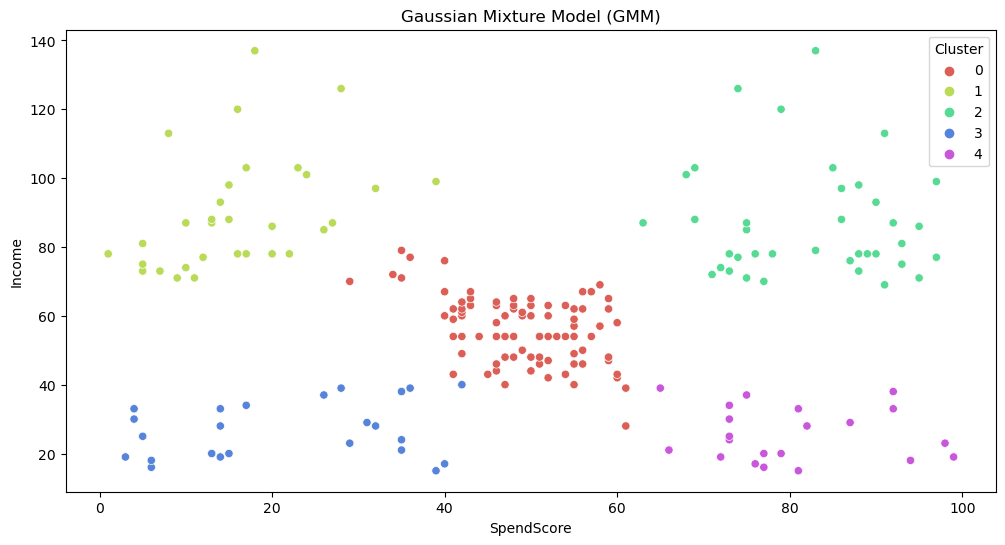

In [6]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x = X['SpendScore'], y = X['Income'], hue=X['Cluster'], palette=sns.color_palette('hls', np.unique(gmm_labels).shape[0]))
plt.plot()
plt.title('Gaussian Mixture Model (GMM)')
plt.show()

---

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** is a density-based clustering algorithm that groups together data points based on their density. Unlike some other clustering algorithms, DBSCAN can discover clusters of arbitrary shape and handle noise or outliers effectively. It does not require specifying the number of clusters in advance, making it a popular choice in various applications.<br>
The core idea of DBSCAN is around concept of dense regions. The assumption is that natural clusters are composed of densely located points. This requires definition of “dense region”. To do these two parameters are required for DBSCAN algorithm:
- **Eps (ε)** - distance
- **MinPts** - Minimum number of points within distance

In DBSCAN there are two major hyperparameters:
* `eps`
* `min_samples`

It is difficult arbitrarily to say what values will work the best. Therefore, I will first create a matrix of investigated combinations.

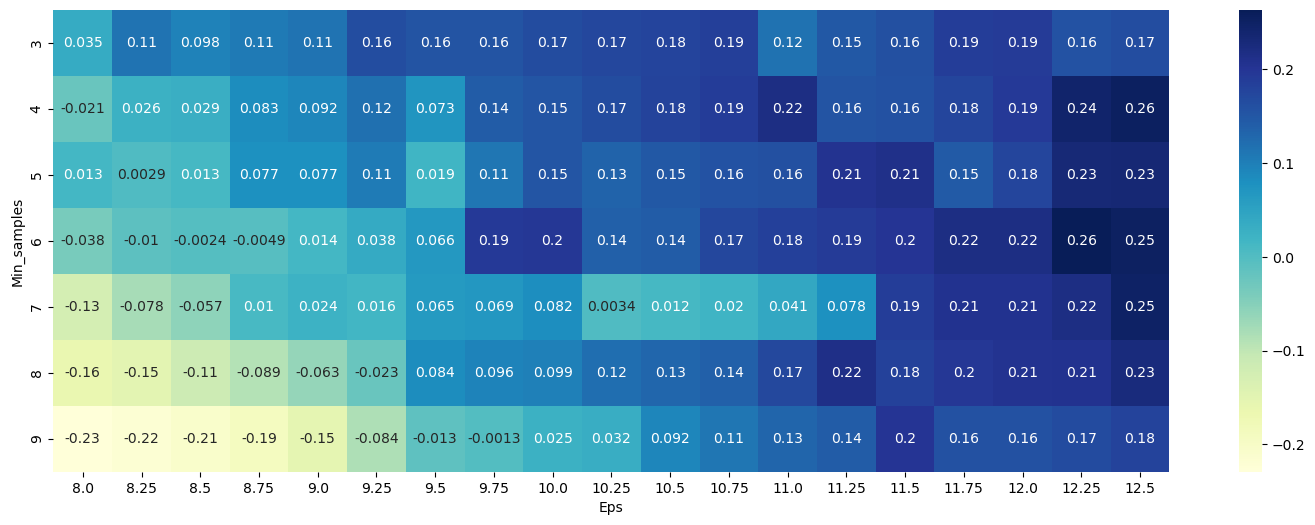

In [7]:
eps = np.arange(8, 12.75, 0.25) # eps values to be investigated
min_samples = np.arange(3, 10) # min_samples values to be investigated
DBSCAN_params = list(product(eps, min_samples))
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_cluster = DBSCAN(eps = p[0], min_samples = p[1]).fit(X)
    no_of_clusters.append(len(np.unique(DBS_cluster.labels_)))
    sil_score.append(silhouette_score(X, DBS_cluster.labels_))

tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score
pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Global Maximum is 0.26 for `eps` = 12.5 & `min_samples` = 4.

In [8]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X)
DBSCAN_clustered = X.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


DBSCAN created 5 clusters plus outliers cluster (-1). Sizes of clusters 0-4 vary significantly - some have only 4 or 8 observations. There are 18 outliers.

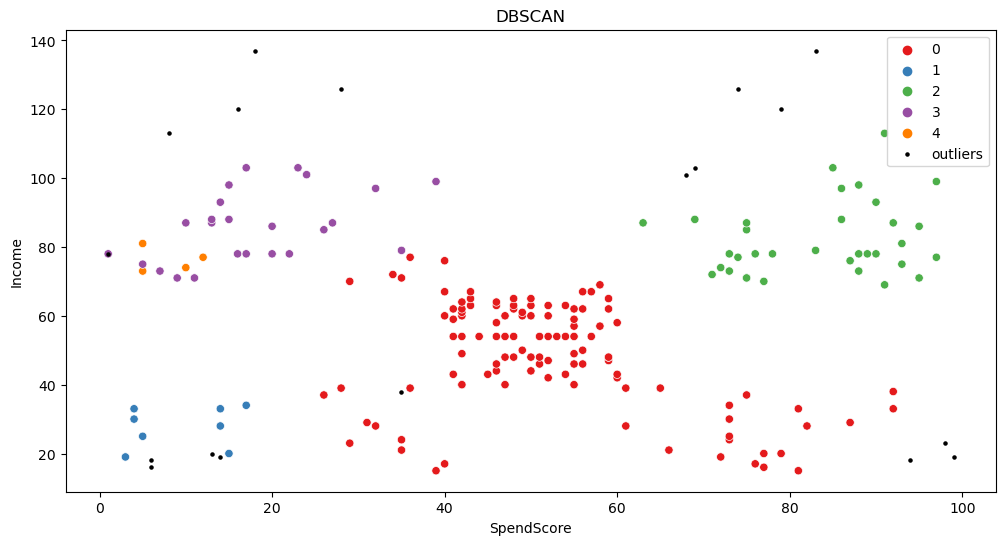

In [9]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(x = 'SpendScore', y = 'Income', hue='Cluster', data = DBSCAN_clustered[DBSCAN_clustered['Cluster'] != -1], palette='Set1', legend = 'full')
ax.scatter(y = outliers['Income'], x = outliers['SpendScore'], s=5, label='outliers', c="k")
ax.legend()
plt.plot()
plt.title('DBSCAN')
plt.show()

The graph above shows that there are some outliers - these points do not meet distance and minimum samples requirements to be recognised as a cluster.

DBSCAN failed to generate reasonable clusters. It is most likely because DBCSAN tries to find clusters based on the density of points. If one of our clusters is less dense than others DBSCAN will produce suboptimal results by not recognising the least dense group as a cluster. <br> In turn, Gaussian Mixture Model (GMM) created reasonable 5 clusters.

----

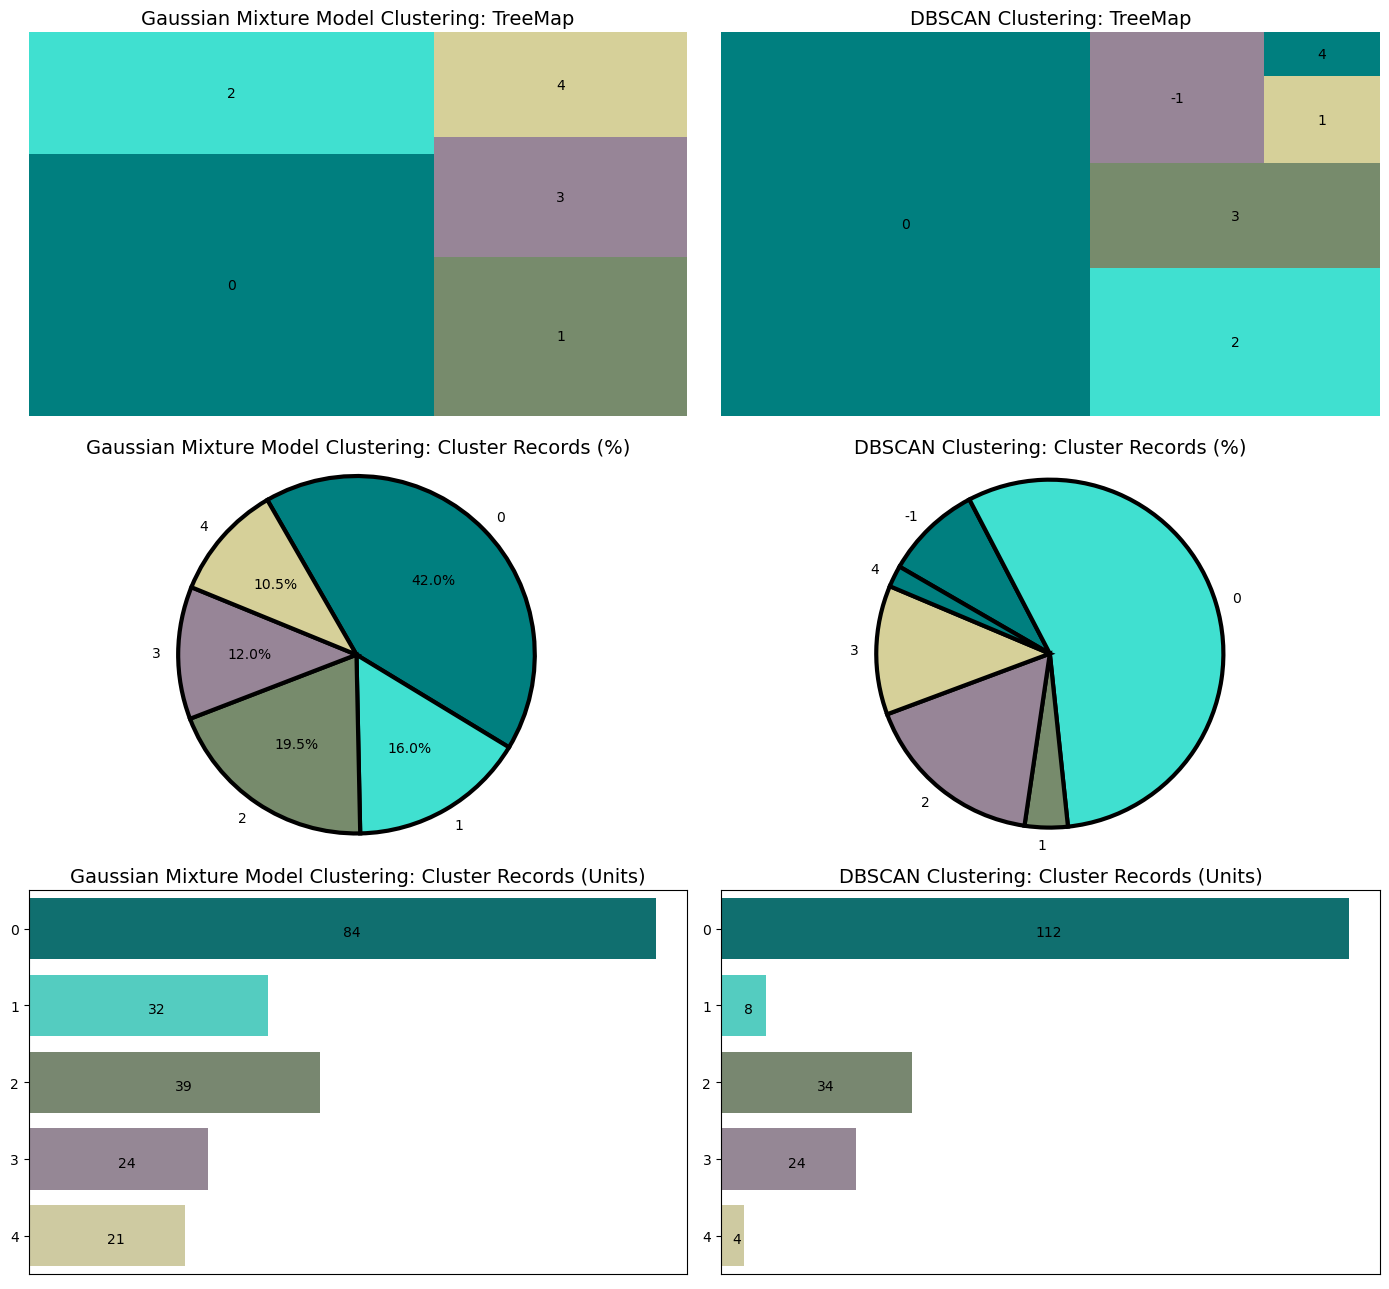

In [14]:
plt.subplots(figsize=(14,13))
my_pal = ('#007f7f','#40E0D0', '#778b6c', '#978597', '#d6d099')
my_col = ('#00C78C', '#bda27e', '#e5593f', '#386890','#e1e1bd')

plt.subplot(3, 2, 1)
plt.title('Gaussian Mixture Model Clustering: TreeMap', fontsize = 14)
labels = X['Cluster'].value_counts().index.get_level_values(0).tolist()
sizes = X['Cluster'].value_counts().reset_index().Cluster.values.tolist()
squarify.plot(sizes = sizes, label = labels, color = my_pal)
plt.axis('off')

plt.subplot(3, 2, 2)
plt.title('DBSCAN Clustering: TreeMap', fontsize = 14)
labels = DBSCAN_clustered['Cluster'].value_counts().index.get_level_values(0).tolist()
sizes = DBSCAN_clustered['Cluster'].value_counts().reset_index().Cluster.values.tolist()
squarify.plot(sizes = sizes, label = labels, color = my_pal)
plt.axis('off')

plt.subplot(3, 2, 3)
plt.title('Gaussian Mixture Model Clustering: Cluster Records (%)', fontsize = 14)
sizes = X['Cluster'].value_counts().sort_index() / (X['Cluster'].value_counts().sum()*100)
labels = sizes.index
plt.pie(sizes, labels = labels, colors=my_pal, counterclock=False, startangle = 120, wedgeprops={'edgecolor' : 'black','linewidth': 3, 'antialiased': True}, autopct='%1.1f%%')
plt.axis('equal')
plt.tight_layout()

plt.subplot(3, 2, 4)
plt.title('DBSCAN Clustering: Cluster Records (%)', fontsize = 14)
sizes = DBSCAN_clustered['Cluster'].value_counts().sort_index() / (DBSCAN_clustered['Cluster'].value_counts().sum()*100)
labels = sizes.index
plt.pie(sizes, labels = labels, colors=my_pal, counterclock=False, startangle = 150, wedgeprops={'edgecolor' : 'black','linewidth': 3, 'antialiased': True})
plt.axis('equal')
plt.tight_layout()

plt.subplot(3, 2, 5)
plt.title("Gaussian Mixture Model Clustering: Cluster Records (Units)", fontsize = 14)
order = [0,1,2,3,4]
ax = sns.countplot(y = 'Cluster', data = X, palette = my_pal, order = order)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_width()),  ((p.get_x() + p.get_width() + 0.05)/2, p.get_y()+0.5))
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.tight_layout()

plt.subplot(3, 2, 6)
plt.title("DBSCAN Clustering: Cluster Records (Units)", fontsize = 14)
order = [0,1,2,3,4]
ax = sns.countplot(y = 'Cluster', data = DBSCAN_clustered, palette = my_pal, order = order)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_width()),  ((p.get_x() + p.get_width() + 0.05)/2, p.get_y()+0.5))
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.tight_layout()

plt.show()